In [1]:
import email.parser
import os, sys, stat
import shutil
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
import nltk

import keras
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense, Embedding, Flatten, Input
from keras.layers import LSTM,Bidirectional,Reshape, add, concatenate, Activation, Conv1D, BatchNormalization, Dropout, MaxPooling1D
from collections import Counter
from keras_tqdm import TQDMNotebookCallback
from keras.models import Model

from bs4 import BeautifulSoup

Using TensorFlow backend.


In [6]:
def ExtractSubPayload (filename):
    global count
    global afterEleminateCount
    ''' Extract the subject and payload from the .eml file.
    
    '''
    if not os.path.exists(filename): # dest path doesnot exist
        print ("ERROR: input file does not exist:", filename)
        os.exit(1)
    fp = open(filename)
    count+=1
    try:
        msg = email.message_from_file(fp)
        payload = msg.get_payload()
        if type(payload) == type(list()) :
            soup = BeautifulSoup(payload[0]) # only use the first part of payload
            txt = soup.get_text()
            txt = ' '.join(txt.split())
            i = txt.find("Content-Transfer-Encoding")
            payload = txt[i + len("Content-Transfer-Encoding"):].split(maxsplit=2)[2]
        else:
            soup = BeautifulSoup(payload)
            txt = soup.get_text()
            txt = ' '.join(txt.split())
            i = txt.find("Content-Transfer-Encoding")
            payload = txt[i + len("Content-Transfer-Encoding"):].split(maxsplit=2)[2]
        sub = msg.get('subject')
        sub = str(sub)
        if type(payload) != type('') :
            payload = str(payload)

        afterEleminateCount+=1;
        return sub + payload
    except Exception as e:
        #print(fp)
        #print (count)
        removedList.append(count)

In [7]:
def ExtractBodyFromDir ( srcdir, dstdir ):
    global dataX
    global raw_text
    '''Extract the body information from all .eml files in the srcdir and 
    
    save the file to the dstdir with the same name.'''
    #if not os.path.exists(dstdir): # dest path doesnot exist
     #   os.makedirs(dstdir)  
    files = os.listdir(srcdir)
    files = sorted(files)
    for file in files:
        srcpath = os.path.join(srcdir, file)
        dstpath = os.path.join(dstdir, file)
        src_info = os.stat(srcpath)
        if stat.S_ISDIR(src_info.st_mode): # for subfolders, recurse
            ExtractBodyFromDir(srcpath, dstpath)
        else:  # copy the file
            body = ExtractSubPayload (srcpath)
            if body !=None:
                #dstfile = open(dstpath, 'w')
                #dstfile.write(body)
                #dstfile.close()
                dataX.append(body)
                raw_text += body

In [122]:
count=-1
removedList=[]
afterEleminateCount=0
dataX = []
raw_text = ""

srcdir = "./TRAINING/"

if not os.path.exists(srcdir):
    print ('The source directory %s does not exist, exit...' % (srcdir))
    sys.exit()

dstdir = "./Output"
if not os.path.exists(dstdir):
    print ('The destination directory is newly created.')
    os.makedirs(dstdir)

ExtractBodyFromDir ( srcdir, dstdir ) 


/home/chenxukun/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/chenxukun/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/home/chenxukun/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5.asp



" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document

In [123]:
raw_text = raw_text.lower()
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))


print (chars)
chars = chars[:71]
chars.append('UNK')
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))
print (chars)
# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Unique chars: ", n_vocab)

['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x92', '\x93', '\x94', '\x95', '\x97', '\x99', '£', '©', '«', '\xad', '®', '°', '²', '·', '¹', '»', 'è', 'é', 'ó', 'ö', 'а', 'б', 'в', 'д', 'е', 'ж', 'и', 'й', 'к', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ш', 'щ', 'я', 'ё', 'ב', 'ג', 'ד', 'ו', 'י', 'ם', 'ע', 'ר', 'ת', '\u200f', '‑', '–', '—', '‘', '’', '“', '”', '•', '…', '™', '→', '≡', '≥', '─', '│', '┌', '┐', '└', '┘', '修', '木', '青', '�']
['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', '

In [124]:
f = open('SPAMTrain.label', 'r')
x = f.readlines()
dataYdebug = [i for j, i in enumerate(x) if j not in removedList]
test = "".join(dataYdebug )
dstfile = open("processedlabel", 'w')
dstfile.write(test)
dstfile.close()
dataY = list(map(lambda x:x.split()[0], dataYdebug))
#dataY

In [125]:
print(len(dataY))
print(dataY.count('1')/len(dataY))

3429
0.7223680373286673


In [126]:
maxLen = 300
lensLst = []
for x in range(0,len(dataX)):
    dataX[x] = dataX[x].lower()
    dataX[x] = [s if s in char_to_int.keys() else "UNK" for s in dataX[x]]
    dataX[x] =np.array([char_to_int[w] for w in dataX[x]])
dataX = sequence.pad_sequences(dataX, maxlen=maxLen, padding='post', truncating='post', value=n_vocab)


In [127]:
dataX =  np.reshape(dataX, (-1, maxLen))
# normalize
#dataX = dataX / float(n_vocab+1)
print(dataX[1])

[35 59 56 41 53 37  2  2 47 49 62 45  2 48 45 58  2 21  2 48 55 61 58  2 58
 55 44 45 55 56 45 58 46 55 58 53 41 54 43 45  3  2 19 18 18  7  2 47 61 41
 58 41 54 60 45 45 44  2 60 55  2 59 45 45  2 41 54  2 49 54 43 58 45 41 59
 45  2 49 54  2 59 49 66 45  2 41 54 44  2 63 49 44 60 48  2 48 60 60 56 28
 17 17 56 47 16 45 64 57 61 53 52 55 41 46 16 43 55 53 17 72 72 72 72 72 72
 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72]


In [128]:
dataX.shape

(3429, 300)

In [129]:
dataY =keras.utils.to_categorical(dataY, 2)

In [130]:
dataX,dataY =shuffle(dataX,dataY)

In [131]:
dataX.shape
X = np.reshape(dataX, (-1, maxLen, 1))
X.shape

(3429, 300, 1)

In [132]:
#making a train / test split
emailCount = len(dataX)
test_split = int(emailCount*0.9)

x_train, y_train = dataX[0:test_split], dataY[0:test_split]
x_test, y_test = dataX[test_split:], dataY[test_split:] 

In [133]:
from keras import optimizers
batch_size = 32
max_features = len(char_to_int)
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

In [134]:
sentenceLen = dataX.shape[1]
vocabSize = len(char_to_int)
embeddingOutputSize = 20

In [135]:
y_test.shape

(343, 2)

In [136]:
dataX.shape

(3429, 300)

In [137]:
inp = Input(shape=(X.shape[1],), dtype='int32')
embedded = Embedding(output_dim=embeddingOutputSize, 
                     input_dim=vocabSize, input_length=sentenceLen,
                    trainable=True)(inp)
x = LSTM(64, return_sequences=True)(embedded)
x = LSTM(64, go_backwards=True)(x)
x = Dropout(0.2)(x)
output = Dense(dataY.shape[1], activation ='softmax')(x)
model = Model(inputs = inp, outputs=output )
model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [138]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 300)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 300, 20)           1440      
_________________________________________________________________
lstm_27 (LSTM)               (None, 300, 64)           21760     
_________________________________________________________________
lstm_28 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 130       
Total params: 56,354
Trainable params: 56,354
Non-trainable params: 0
_________________________________________________________________


In [143]:

# Fit the model on the batches generated by datagen.flow().
hist = model.fit(x_train, y_train,batch_size=batch_size,
                    epochs=20,
                    validation_data=(x_test, y_test),
                    verbose=0,callbacks=[TQDMNotebookCallback(leave_inner=True,leave_outer=True)])

In [36]:
x_train.shape

(3086, 1000)

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

{'val_loss': [0.22503959559143111, 0.25535709795381861, 0.21250823526792553, 0.19420495429469961, 0.19809636764727945, 0.22358565466918334, 0.25584027649014751, 0.24154754847548793, 0.21622789570784778, 0.41943056798884887, 0.19658895571099774, 0.24231204303638582, 0.18646884042737089, 0.17359899058286371, 0.16415898732124196, 0.15321365702604064, 0.16788890771024775, 0.15680034080677754, 0.15690300407284549, 0.18207745584211266], 'val_acc': [0.90379008746355682, 0.8892128286834361, 0.91545189643392755, 0.91545189573882968, 0.92128279952891712, 0.91545189712902553, 0.88046647369340281, 0.89212828127357768, 0.90962099264384011, 0.77259475566207836, 0.93002915590914625, 0.88338192489334866, 0.92128279952891712, 0.94460641468926698, 0.93877551089917954, 0.96209912536443154, 0.95626822157434399, 0.94752186588921283, 0.95335276967930027, 0.94169096418441911], 'loss': [0.27830564162596744, 0.26547744555358987, 0.25320902345092439, 0.23859729325701801, 0.22915173698112862, 0.23128765786690753

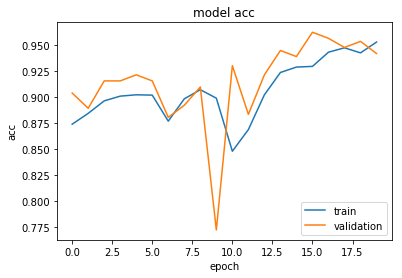

In [144]:
plot_train(hist)
print (hist.history)